In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

In [2]:
# Load the data
sms = pd.read_csv(r'//Users/shuvradas/Downloads/spam.csv', encoding='latin1')
sms = sms[["v1", "v2"]]
sms.columns = ['label', 'text']

In [3]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Tokenization
def tokenize_text(text):
    return word_tokenize(text)

sms['tokenized_text'] = sms['text'].apply(tokenize_text)

[nltk_data] Downloading package punkt to /Users/shuvradas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuvradas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

sms['cleaned_text'] = sms['tokenized_text'].apply(remove_stopwords)

In [5]:
# EDA: Most frequent words
def get_most_frequent_words(tokens_list, n=10):
    words = [word for tokens in tokens_list for word in tokens]
    word_freq = Counter(words).most_common(n)
    return word_freq

spam_messages = sms[sms['label'] == 'spam']
ham_messages = sms[sms['label'] == 'ham']

spam_word_freq = get_most_frequent_words(spam_messages['cleaned_text'])
ham_word_freq = get_most_frequent_words(ham_messages['cleaned_text'])

print("Top 10 words in spam messages:", spam_word_freq)
print("Top 10 words in ham messages:", ham_word_freq)

Top 10 words in spam messages: [('.', 1005), ('!', 542), (',', 371), ('call', 187), ('&', 178), ('2', 176), ('?', 174), (':', 163), ('Call', 138), ('4', 122)]
Top 10 words in ham messages: [('.', 3881), (',', 1500), ('?', 1367), ('...', 1124), ('!', 839), (';', 762), ('&', 738), ('u', 725), ('..', 669), (':', 554)]


In [6]:
# EDA: Most frequent bi-grams and tri-grams
def get_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(grams) for grams in n_grams]

def get_most_frequent_ngrams(tokens_list, n=2, top_n=10):
    ngrams_list = [ngram for tokens in tokens_list for ngram in get_ngrams(tokens, n)]
    ngram_freq = Counter(ngrams_list).most_common(top_n)
    return ngram_freq

spam_bigrams = get_most_frequent_ngrams(spam_messages['cleaned_text'], 2)
ham_bigrams = get_most_frequent_ngrams(ham_messages['cleaned_text'], 2)

print("Top 10 bi-grams in spam messages:", spam_bigrams)
print("Top 10 bi-grams in ham messages:", ham_bigrams)

spam_trigrams = get_most_frequent_ngrams(spam_messages['cleaned_text'], 3)
ham_trigrams = get_most_frequent_ngrams(ham_messages['cleaned_text'], 3)

print("Top 10 tri-grams in spam messages:", spam_trigrams)
print("Top 10 tri-grams in ham messages:", ham_trigrams)

Top 10 bi-grams in spam messages: [('. Call', 80), ('* *', 61), ('URGENT !', 34), ('& Cs', 32), ('& C', 30), ('! Call', 27), ('! Txt', 26), ('Please call', 26), ('4 *', 25), ('. Txt', 23)]
Top 10 bi-grams in ham messages: [('& lt', 314), ('lt ;', 314), ('& gt', 314), ('gt ;', 314), ('# &', 280), ('; #', 278), (': )', 251), (': -', 126), ('. .', 121), ('- )', 113)]
Top 10 tri-grams in spam messages: [('* * *', 51), ('prize GUARANTEED .', 19), ('GUARANTEED . Call', 19), ("& C 's", 16), ('land line .', 16), ('. Valid 12hrs', 15), ('! trying contact', 13), ('Identifier Code :', 13), ('line . Claim', 13), ('PRIVATE ! 2003', 13)]
Top 10 tri-grams in ham messages: [('& lt ;', 314), ('& gt ;', 314), ('; # &', 278), ('lt ; #', 276), ('# & gt', 276), (': - )', 103), ('& amp ;', 86), ('gt ; .', 54), ('. . .', 45), ("'ll call later", 41)]


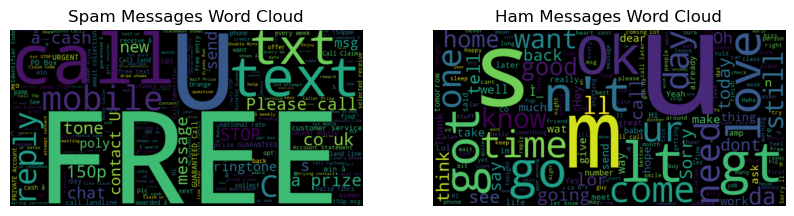

In [7]:
# EDA: Word clouds
spam_words = [word for tokens in spam_messages['cleaned_text'] for word in tokens]
ham_words = [word for tokens in ham_messages['cleaned_text'] for word in tokens]

spam_wordcloud = WordCloud(width=800, height=400).generate(' '.join(spam_words))
ham_wordcloud = WordCloud(width=800, height=400).generate(' '.join(ham_words))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.show()

In [8]:
# Convert text to vectors using Bag-of-Words
vectorizer = CountVectorizer(stop_words='english')
X_bow = vectorizer.fit_transform(sms['text'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_bow, sms['label'], test_size=0.2, random_state=42)

# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
f1_bow = f1_score(y_test, y_pred, pos_label='spam')

print(f"F1-Score using Bag-of-Words: {f1_bow}")

F1-Score using Bag-of-Words: 0.9266666666666666


In [9]:
# Convert text to vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(sms['text'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, sms['label'], test_size=0.2, random_state=42)

# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
f1_tfidf = f1_score(y_test, y_pred, pos_label='spam')

print(f"F1-Score using TF-IDF: {f1_tfidf}")

F1-Score using TF-IDF: 0.8679245283018869


In [10]:
# Text preprocessing function (without lemmatization)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove email addresses
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sms['preprocessed_text'] = sms['text'].apply(preprocess_text)

# Convert to TF-IDF with preprocessing
X_tfidf_preprocessed = tfidf_vectorizer.fit_transform(sms['preprocessed_text'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_preprocessed, sms['label'], test_size=0.2, random_state=42)

# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
f1_tfidf_preprocessed = f1_score(y_test, y_pred, pos_label='spam')

print(f"F1-Score using TF-IDF with preprocessing: {f1_tfidf_preprocessed}")

F1-Score using TF-IDF with preprocessing: 0.8679245283018869


In [11]:
# Summarize the scores
print(f"F1-Score using Bag-of-Words: {f1_bow}")
print(f"F1-Score using TF-IDF: {f1_tfidf}")
print(f"F1-Score using TF-IDF with preprocessing: {f1_tfidf_preprocessed}")

F1-Score using Bag-of-Words: 0.9266666666666666
F1-Score using TF-IDF: 0.8679245283018869
F1-Score using TF-IDF with preprocessing: 0.8679245283018869
